In [20]:


import numpy as np
from sklearn import datasets
import seaborn as sns
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

tol = 0.01
eps = 0.01



In [50]:
class SMOModel:
    def __init__(self,X,Y,C,b,kernel):
        self.m = Y.shape[0]
        self.y = Y
        self.X = X
        self.C = C
        self.b = b
        self.kernel = kernel
        self.alphas = np.zeros(self.m)
        self.errors = decision_function(self.alphas, self.y, self.kernel,self.X, self.X, self.b) - self.y


In [198]:
def gaussian_kernel(x, y, sigma=1):
    if np.ndim(x) == 1 and np.ndim(y) == 1:
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

def linear_kernel(X1,X2):
    return np.inner(X1,X2)

def objective_function(alphas, y, kernel, X):
    return np.sum(alphas) - 0.5 * np.sum((y[:, None] * y[None, :]) * kernel(X, X) * (alphas[:, None] * alphas[None, :]))

def decision_function(alphas, y, kernel, X_train, x_test, b):
    result = (alphas * y) @ kernel(X_train, x_test) - b
    return result

In [256]:
def takeStep(i1, i2, model):
    
    if i1 == i2: #If the alphas are the same - skip
        return 0, model
    
    # Extraction of the variables from the cache
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    
    s = y1*y2
    
    #Calculate the upper and lower boundary (depending on the value of the labels y1 & y2)
    if y1 == y2:
        L = max(0 , alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    else:
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
     
    #Skip if the lower and the upper bounds are the same
    if L == H:
        return 0, model
    
    #Compute the differnet kernels
    k11 = model.kernel(model.X[i1],model.X[i1])
    k12 = model.kernel(model.X[i1],model.X[i2])
    k22 = model.kernel(model.X[i2],model.X[i2])
    
    #Compute eta
    eta = k11 + k22 - 2*k12
    
    #If eta is positive - compute a2 as function of the old a2, the errors, the label and eta.
    #(This solution can be reached analytically without the need for complicated optimization,
    #which is the advantage of the SMO algorithm)
    if eta > 0:
        a2 = alph2 + (y2*(E1 -E2))/eta
        
        #Clip a2 by the bounds L and H
        if a2 < L:
            a2 = L
        elif a2 > H:
            a2 = H
    else:
        #Here we make copy because we don't want to chahge the original alphas values, we just wanna to compute the
        #different objective functions for a2.
        alphas_adj = model.alphas.copy()
        
        alphas_adj[i2] = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) # Objective function at a2=L
        
        alphas_adj[i2] = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X) # Objective function at a2=H
        
        #Clip a2 at the same way as mentioned in the article
        if Lobj < (Hobj - eps):
            a2 = L
        elif Lobj > (Hobj + eps):
            a2 = H
        else:
            a2 = alph2
    
    #If a2 value is very small - enter a value of 0        
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    #Skip this step if the change in a2 is less than *eps(a2_new + a2_old + eps)       
    if abs(a2 - alph2) < eps*(a2+alph2+eps):
        return 0, model
    
    #Compute a1 as a function of the old a1, a2 and s.
    #(This solution can be reached analytically without the need for complicated optimization,
    #which is the advantage of the SMO algorithm)
    a1 = alph1 + s*(alph2 - a2)
      
    # Update value of the threshold b by the new a1 & a2, Compute both possible values for the new treshold.
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
     
    #Update the threshold according to the a that does not violate the conditions, 
    #if both don't violate the conditions than new_b = average of a1 and a2 
    if 0 < a1 and a1 < model.C:
        b = b1
    elif 0 < a2 and a2 < model.C:
        b = b2
    else:
        b = (b1 + b2) * 0.5
    
    #Push the new alphas values to cache
    model.alphas[i1] = a1
    model.alphas[i2] = a2

    #Update error cache to 0 if a1 ,a2 are in the bounds range
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph and alph < model.C:
            model.errors[index] = 0.0
     
    
    #Update error cache of the other alpahs
    NonOpt = list(filter(lambda n: n != i1 and n != i2, list(range(model.m))))
    
    model.errors[NonOpt] = model.errors[NonOpt] + y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[NonOpt]) +y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[NonOpt]) + model.b - b
    
    #Update b
    model.b = b
    
    return 1, model


In [257]:
def examineExample(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2*y2
    
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        #if (number of non-zero & non-C alpha > 1)
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            
            #This is the heuristic method I found online
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors) 
                
            step, model = takeStep(i1, i2, model)
            
            if step:
                return 1, model
         
        #loop over all non-zero and non-C alpha, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0], np.random.choice(np.arange(model.m))):
            step, model = takeStep(i1, i2, model)
            if step:
                return 1, model
        
        #loop over all possible i1, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step, model = takeStep(i1, i2, model)
            if step:
                return 1, model
            
    return 0, model

In [258]:
def train(model):
    numChanged = 0
    examineAll = 1

    while numChanged > 0 or examineAll:
        numChanged = 0
        if examineAll:
            
            for i in range(model.m):
                res , model = examineExample(i, model)
                numChanged += res
                
        else:
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                res , model = examineExample(i, model)
                numChanged += res
                
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1
    return model

In [259]:
def predict(model,X_test):
    result = np.zeros(X_test.shape[0])
  
    for i in range(X_test.shape[0]):
       
        result[i] = decision_function(model.alphas, model.y, model.kernel, model.X, X_test[i], model.b)
        
    return result

In [260]:
PATH_TO_TEST_TRAIN_DATA = 'Tangni/Data/'

#### define dataset
series1 = read_csv(PATH_TO_TEST_TRAIN_DATA + '1-3.csv', header=0, usecols=[0,1], index_col=0) 
data1 = series1.values

series2 = read_csv(PATH_TO_TEST_TRAIN_DATA + '2-12.csv', header=0, usecols=[0,1], index_col=0) 
data2 = series2.values

series3 = read_csv(PATH_TO_TEST_TRAIN_DATA + '3-6.csv', header=0, usecols=[0,1], index_col=0) 
data3 = series3.values

series4 = read_csv(PATH_TO_TEST_TRAIN_DATA + '4-15.csv', header=0, usecols=[0,1], index_col=0) 
data4 = series4.values

series5 = read_csv(PATH_TO_TEST_TRAIN_DATA + '5-15.csv', header=0, usecols=[0,1], index_col=0) 
data5 = series5.values


In [261]:
Data = data5[:62]

In [262]:
Label =Data[1:]

In [263]:
X_train, y_train = Data[:-1], Label.reshape((len(Label)))

In [280]:
model = SMOModel(X_train, y_train, C=100, b=1, kernel=gaussian_kernel)
    
np.random.seed(0)
model = train(model)

In [281]:
pre = predict(model, X_train)

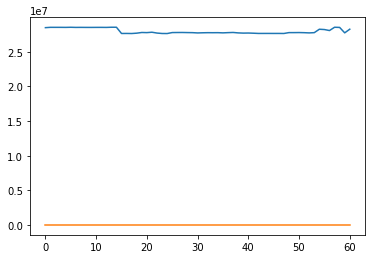

In [282]:
plt.plot(pre)
plt.plot(y_train)